## Step Project
У цьому проекті ми виконаємо повний аналіз набору даних "IKEA"(каталог товарів "IKEA"), який містить інформацію про товар: назва, ціна, опис, дизайнер, висоту, ширину та глибину виробу.
Ми пройдемо наступні етапи:

1. Завантаження даних
2. Дослідницький аналіз даних (EDA): описова статистика, візуалізація, перевірка на пропущені значення
3. Формулювання та перевірка гіпотез:
    - Гіпотеза 1: Розподіл цін  в наборі має ознаки не нормального розподілу
    - Гіпотеза 2: Товари, які мають варіації кольорів мають вищу ціну
    - Гіпотеза 3: Товари, які мають більші габарити  мають вищу ціну

4. Побудова моделі для прогнозування ціни на меблі  із застосуванням конвеєра обробки даних та крос-валідації

### 01. Завантажимо всі необхідні бібліотеки
Спершу імпортуємо всі необхідні бібліотеки для аналізу даних, візуалізації та побудови моделей

In [1]:
import requests # бібліотека для отримання вмісту документа за вказаною URL-адресою
import os
import re # модуль для роботи з регулярними виразами
import seaborn as sns # бібліотека для візуалізацій
import matplotlib.pyplot as plt # бібліотека для візуалізацій
import pandas as pd # бібліотека для аналізу та обробки даних
import numpy as np # для проведення обчислень
from scipy import stats # для статистичних розрахунків
from scipy.stats import mannwhitneyu, kruskal #
from scipy.stats import ranksums #
from scipy.stats import shapiro # для оцінки гіпотези
from scipy.stats import ttest_ind # для оцінки гіпотези
from scipy.stats import wilcoxon # для оцінки гіпотези
from statsmodels.stats.multicomp import pairwise_tukeyhsd # для аналізу даних, тестування гіпотез
import statsmodels.api as sm #   тестування гіпотез використовуючи метод лінійної регресії
import statsmodels.formula.api as smf #  для аналізу даних, тестування гіпотез

import sklearn as sk # бібліотека для машинного навчання, пропонує різні функції та класи для попередньої обробки даних і моделювання
from sklearn.model_selection import train_test_split # для того , щоб випадково розділити дані на тестовий і навчальні(тренувальні) набори
from sklearn.compose import ColumnTransformer # дає  можливість застосувати різні транформатори до різних стовпців
from sklearn.compose import make_column_transformer # функція приймає в якості аргументів кортежі з трансформатором і списком стовпців, до яких цей трансформатор повинен бути застосований.
from sklearn.pipeline import Pipeline # конвеєр, дає можливість об'єднати кілька операцій в одну, тобто зібрати разом імпутування, кодування і масштабування
from sklearn.impute import SimpleImputer # замінює відсутні значення певним єдиним значенням
from sklearn.preprocessing import  FunctionTransformer # дозволяє застосувати будь-яку користувацьку функцію до вхідних даних у вигляді елемента в конвеєрі(Pipeline)
from sklearn.preprocessing import StandardScaler # використовується для масштабування, стандартизує ознаки, роблячи середнє рівним 0 і дисперсію рівним 1.
from sklearn.preprocessing import OneHotEncoder # використовується для кодування номінальних даних категоріального типу; перетворювач, який заміняє колонку з категоріями на кілька з 0,1,2...
from sklearn.neighbors import KNeighborsRegressor # модель регресія найближчих сусідів
from sklearn.tree import DecisionTreeRegressor # модель дерево рішень
from sklearn.ensemble import RandomForestRegressor # комбінація кількох дерев
from sklearn.ensemble import GradientBoostingRegressor #
from sklearn.linear_model import LinearRegression # модель лінійної регресії
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV # пошук найкращих гіперпараметрів, при яких модель показує найкращі результати
from sklearn.model_selection import KFold, cross_val_score # оціннка якості моделі, обчислення балу перехресної перевірки
from sklearn.model_selection import RandomizedSearchCV # пошук найкращих гіперпараметрів, набагато швидше а ніж GridSearchCV, використовується частіше для великих наборів даних.
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score #метрики оцінки якості регресійної моделі

### 02. Підготовка файла та завантаження

In [2]:
def download_document(file_name, document_url):
    if os.path.exists(file_name):
        pass
    else:
        response=requests.get(document_url)
        if response.status_code==200:
            with open(file_name,'wb') as file:
                file.write(response.content)
        else:
            print(f"Failed to download the document. Status code: {response.status_code}")


file_name='ikea.csv'
document_url='https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv'

download_document(file_name,document_url)

### 03. Дослідницький аналіз даних (EDA)
На цьому етапі проведемо:

- **Описову статистику:** переглянемо перші рядки даних, основні статистичні показники, перевіримо на пропущені значення.
- **Візуалізацію:** побудуємо діаграми підрахунку, гістограми, коробкові діаграми та матрицю кореляцій з тепловою картою для виявлення зв’язків між ознаками.

In [3]:
df_ikea=pd.read_csv('ikea.csv')
display(df_ikea)

,Unnamed: 0,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
0,0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0
1,1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0
2,2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN
3,3,80155205,STIG,Bar furniture,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0
4,4,30180504,NORBERG,Bar furniture,225.0,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3689,3689,99157902,ELVARLI,Wardrobes,750.0,SR 820,True,https://www.ikea.com/sa/en/p/elvarli-1-section...,No,"1 section, 92x51x222-350 cm",Ehlén Johansson,50.0,NaN,91.0
3690,3690,9158152,ELVARLI,Wardrobes,1572.0,"SR 1,755",True,https://www.ikea.com/sa/en/p/elvarli-2-section...,No,"2 sections, 135x51x222-350 cm",Ehlén Johansson,50.0,NaN,135.0
3691,3691,59157541,ELVARLI,Wardrobes,924.0,"SR 1,050",True,https://www.ikea.com/sa/en/p/elvarli-2-section...,No,"2 sections, 175x51x222-350 cm",Ehlén Johansson,50.0,NaN,175.0
3692,3692,89157573,ELVARLI,Wardrobes,2745.0,"SR 3,130",True,https://www.ikea.com/sa/en/p/elvarli-3-section...,No,"3 sections, 178x51x222-350 cm",Ehlén Johansson,50.0,NaN,178.0


#### Спочатку виведемо ознайомчу інформацію:

In [4]:
# Виведемо  інформацію про типи даних, які має  наш датасет
print(df_ikea.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694 entries, 0 to 3693
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3694 non-null   int64  
 1   item_id            3694 non-null   int64  
 2   name               3694 non-null   object 
 3   category           3694 non-null   object 
 4   price              3694 non-null   float64
 5   old_price          3694 non-null   object 
 6   sellable_online    3694 non-null   bool   
 7   link               3694 non-null   object 
 8   other_colors       3694 non-null   object 
 9   short_description  3694 non-null   object 
 10  designer           3694 non-null   object 
 11  depth              2231 non-null   float64
 12  height             2706 non-null   float64
 13  width              3105 non-null   float64
dtypes: bool(1), float64(4), int64(2), object(7)
memory usage: 378.9+ KB
None


In [5]:
# Кількість стовпчиків та рядків нашого датасету:
print(df_ikea.shape)

(3694, 14)


In [6]:
# Загальна кількість елементів складає:
print(df_ikea.size)

51716


In [7]:
# Виведемо назви всіх стовпчиків, які містить наш датасет
print(df_ikea.columns)

Index(['Unnamed: 0', 'item_id', 'name', 'category', 'price', 'old_price',
       'sellable_online', 'link', 'other_colors', 'short_description',
       'designer', 'depth', 'height', 'width'],
      dtype='object')


In [8]:
print('\nFirst elements')
print(df_ikea.head(5))
print('\nLast elements')
print(df_ikea.tail(5))
print('\nRandom elements')
print(df_ikea.sample(5))


First elements
   Unnamed: 0   item_id                   name  ... depth  height width
0           0  90420332               FREKVENS  ...   NaN    99.0  51.0
1           1    368814              NORDVIKEN  ...   NaN   105.0  80.0
2           2   9333523  NORDVIKEN / NORDVIKEN  ...   NaN     NaN   NaN
3           3  80155205                   STIG  ...  50.0   100.0  60.0
4           4  30180504                NORBERG  ...  60.0    43.0  74.0

[5 rows x 14 columns]

Last elements
      Unnamed: 0   item_id     name  ... depth  height  width
3689        3689  99157902  ELVARLI  ...  50.0     NaN   91.0
3690        3690   9158152  ELVARLI  ...  50.0     NaN  135.0
3691        3691  59157541  ELVARLI  ...  50.0     NaN  175.0
3692        3692  89157573  ELVARLI  ...  50.0     NaN  178.0
3693        3693  69157376  ELVARLI  ...  50.0     NaN  175.0

[5 rows x 14 columns]

Random elements
      Unnamed: 0   item_id           name  ... depth  height  width
2291        2291  89284712        

In [9]:
# Визначимо кількість данних відсутньо по кожній з колонок
df_ikea.isnull().sum()

,0
Unnamed: 0,0
item_id,0
name,0
category,0
price,0
old_price,0
sellable_online,0
link,0
other_colors,0
short_description,0


*В результаті ми отримаємо, що три стовпчика містять відсутні значення, а саме: 'depth', 'height', 'width'*

In [10]:
# Визначимо скільки унікальних значень містить кожна колонка
print(df_ikea.nunique())

Unnamed: 0           3694
item_id              2962
name                  607
category               17
price                 979
old_price             365
sellable_online         2
link                 2962
other_colors            2
short_description    1706
designer              381
depth                 114
height                193
width                 263
dtype: int64


*У колонці  'item_id' мають всі значення бути унікальними(3694 ), але нажаль ми  бачимо лише 2962 унікальних елемента. Отже дана колонка містить дублікати: 3694-2962=732. Перевіримо це і виведемо ці рядки.*

In [12]:
# Визначимо кількість  дублікатів у стовпчику 'item_id'
print(df_ikea[df_ikea.duplicated(subset='item_id')])

      Unnamed: 0   item_id         name  ... depth  height  width
803          803  30441554  TIMMERVIKEN  ...   NaN    64.0   60.0
805          805  80441556  TIMMERVIKEN  ...   NaN    38.0   60.0
807          807  10443629     GLASSVIK  ...   NaN    38.0   60.0
808          808  80275887       KALLAX  ...  39.0   147.0   77.0
810          810  40033763         IVAR  ...  30.0    83.0   80.0
...          ...       ...          ...  ...   ...     ...    ...
3548        3548  90421911      BRYGGJA  ...  43.0   173.0  120.0
3572        3572   9157261      ELVARLI  ...  35.0     NaN   51.0
3628        3628  99188003      ELVARLI  ...  35.0     NaN  261.0
3676        3676  59315159      ELVARLI  ...  51.0     NaN  258.0
3693        3693  69157376      ELVARLI  ...  50.0     NaN  175.0

[732 rows x 14 columns]


In [13]:
# Вилучаємо дублікати
df_ikea = df_ikea.drop_duplicates(subset=['item_id'], keep='first').reset_index(drop=True)
print(df_ikea.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2962 entries, 0 to 2961
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         2962 non-null   int64  
 1   item_id            2962 non-null   int64  
 2   name               2962 non-null   object 
 3   category           2962 non-null   object 
 4   price              2962 non-null   float64
 5   old_price          2962 non-null   object 
 6   sellable_online    2962 non-null   bool   
 7   link               2962 non-null   object 
 8   other_colors       2962 non-null   object 
 9   short_description  2962 non-null   object 
 10  designer           2962 non-null   object 
 11  depth              1844 non-null   float64
 12  height             2236 non-null   float64
 13  width              2520 non-null   float64
dtypes: bool(1), float64(4), int64(2), object(7)
memory usage: 303.8+ KB
None


*Вилучимо зайві колонки.*
*Це такі колонки, як 'Unnamed: 0', 'item_id', 'link', оскільки вони, на мою думку, не несуть суттєвої інформації для аналізу*

In [14]:
# Вилучимо зайві колонки. Це такі колонки, як 'Unnamed: 0', 'item_id', 'link',
# оскільки вони, на мою думку, не несуть суттєвої інформації для аналізу
df_ikea = df_ikea.drop(columns=['Unnamed: 0','item_id','link'])

In [15]:
print('\nОновлений перелік колонок')
print(df_ikea.columns)


Оновлений перелік колонок
Index(['name', 'category', 'price', 'old_price', 'sellable_online',
       'other_colors', 'short_description', 'designer', 'depth', 'height',
       'width'],
      dtype='object')


*Виконаємо детальний аналіз усіх колонок*

In [16]:
#Виконаємо детальний аналіз усіх колонок
print('\Колонка name:')
print(df_ikea['name'])
print('\n------------------------------')
print('\Унікальні значення')
print(df_ikea['name'].nunique())
print('\n------------------------------')
print('\Кількість записів і наяявність пустих')
print(df_ikea['name'].value_counts())
print(df_ikea['name'].isna().sum())
print('\n------------------------------')

\Колонка name:
0                    FREKVENS
1                   NORDVIKEN
2       NORDVIKEN / NORDVIKEN
3                        STIG
4                     NORBERG
                ...          
2957        PAX / MEHAMN/AULI
2958                  ELVARLI
2959                  ELVARLI
2960                  ELVARLI
2961                  ELVARLI
Name: name, Length: 2962, dtype: object

------------------------------
\Унікальні значення
607

------------------------------
\Кількість записів і наяявність пустих
name
BESTÅ            115
PAX              111
GRÖNLID           82
IVAR              66
BEKANT            64
                ... 
PAX / SEKKEN       1
PAX / VINGROM      1
TORSBY             1
IKEA PS 2012       1
GLASHOLM           1
Name: count, Length: 607, dtype: int64
0

------------------------------


In [17]:
print('\Колонка category:')
print('\nСтатистика колонки category')
print(df_ikea[['category']].describe())
print('\n------------------------------')
print('\Розподіл товарів по категоріях')
print(df_ikea['category'].value_counts())
print('\n------------------------------')
print('\Розподіл товарів по категоріях у відсотках')
print(df_ikea['category'].value_counts(normalize=True).sort_values(ascending=False))
print('\n------------------------------')
print('\Кількість пустих записів')
print(df_ikea['category'].isna().sum())
print('\n------------------------------')

\Колонка category:

Статистика колонки category
                          category
count                         2962
unique                          17
top     Bookcases & shelving units
freq                           548

------------------------------
\Розподіл товарів по категоріях
category
Bookcases & shelving units              548
Chairs                                  438
Sofas & armchairs                       380
Tables & desks                          370
Wardrobes                               220
Beds                                    208
Outdoor furniture                       197
Cabinets & cupboards                    187
Chests of drawers & drawer units        111
TV & media furniture                     89
Children's furniture                     84
Bar furniture                            47
Trolleys                                 23
Nursery furniture                        22
Café furniture                           18
Sideboards, buffets & console tables     10


Отже, маємо 17 унікальних категорій. Найпопулярнішими з яких є: Bookcases & shelving units - 18,5%;  Chairs - 14,8%;  Sofas & armchairs - 12,8%; Tables & desks - 12,5% Але і є категорії, які зовсім нечисельні (<1%). Якимось чином дані категорії можна було згрупувати, наприклад, більш популярні і менш популярні

In [18]:
print('\Колонка designer:')
print(df_ikea['designer'].value_counts())
print('\n------------------------------')
print('\Кількість унікальних значень')
print(df_ikea['price'].nunique())
print('\n------------------------------')
print('\Кількість пустих записів')
print(df_ikea['category'].isna().sum())
print('\n------------------------------')

\Колонка designer:
designer
IKEA of Sweden                                        683
Ehlén Johansson                                       136
Francis Cayouette                                     131
Ola Wihlborg                                          128
Jon Karlsson                                          106
                                                     ... 
IKEA of Sweden/Gustav Carlberg                          1
Chenyi Ke/IKEA of Sweden                                1
Francis Cayouette/Jomi Evers                            1
Ehlén Johansson/Andreas Fredriksson/IKEA of Sweden      1
IKEA of Sweden/Ehlén Johansson/Andreas Fredriksson      1
Name: count, Length: 381, dtype: int64

------------------------------
\Кількість унікальних значень
979

------------------------------
\Кількість пустих записів
0

------------------------------


Колонка з інформацією про дизайнерів містить дуже різнорідні записи: імена дизайнерів, групи дизайнерів...  Створимо нову колонку designer_new, яка буде містити перетворені, почищені дані з колонки designer в більш прийнятному вигляді.

In [19]:
# Чистимо дизайнерів
def clean_designer(value, removeIKEA=False, empty_value='unknow'):
  if not isinstance(value,str):# перевіряємо чи є value рядком
    return value
  if len(value)>0 and value[0].isdigit(): # чи перший символ в рядку є цифрою в діапазоні від 0 до 9
    return empty_value
  designers=value.split('/') #розділяє рядок, розділений '/' на підрядки
  if removeIKEA:
    try:
      designers.remove('IKEA of Sweden')
    except:
      pass
  if len(designers)>0:
    return '/'.join(sorted(designers))# впорядкуємо за алфавітом дизайнерів у списку + об'єднання в один рядок
  else:
    return empty_value

# Застосовуємо  функцію і робимо нову колонку
df_ikea['designer_new'] = df_ikea['designer'].apply(clean_designer)

In [20]:
print('\Колонка designer_new:')
print(df_ikea['designer_new'].value_counts())
print('\n------------------------------')

\Колонка designer_new:
designer_new
IKEA of Sweden                                    683
Ehlén Johansson/IKEA of Sweden                    138
Ehlén Johansson                                   136
Francis Cayouette                                 131
Ola Wihlborg                                      128
                                                 ... 
Gustav Carlberg/IKEA of Sweden/Johanna Asshoff      1
Chris Martin/IKEA of Sweden                         1
J Karlsson/W Chong                                  1
Francis Cayouette/Gustav Carlberg                   1
Jomi Evers/Tina Christensen                         1
Name: count, Length: 200, dtype: int64

------------------------------


In [21]:
print('\Кількість пустих записів')
print(df_ikea['designer_new'].isna().sum())
print('\n------------------------------')

\Кількість пустих записів
0

------------------------------


Отже, в результаті перетворяння ми отримали рядки(102) де інформація про дизайнерів невідома

In [22]:
print('\Колонка price:')
print(df_ikea.price.value_counts().sort_values(ascending=False))
print('\n------------------------------')
print('\nСтатистика колонки price')
print(df_ikea['price'].describe())
print('\n------------------------------')
print('\Кількість унікальних записів')
print(df_ikea['price'].nunique())
print('\n------------------------------')
print('\Кількість пустих записів')
print(df_ikea['price'].isna().sum())
print('\n------------------------------')

\Колонка price:
price
395.0     48
195.0     42
595.0     41
175.0     41
995.0     40
          ..
924.0      1
1926.0     1
717.0      1
678.0      1
3500.0     1
Name: count, Length: 979, dtype: int64

------------------------------

Статистика колонки price
count    2962.000000
mean     1108.722552
std      1393.576103
min         3.000000
25%       200.000000
50%       570.000000
75%      1475.000000
max      9585.000000
Name: price, dtype: float64

------------------------------
\Кількість унікальних записів
979

------------------------------
\Кількість пустих записів
0

------------------------------


Отже, дивлячись на статистику колонки price можемо сказати, що середнє арифметичне та медіана  дуже сильно відрізнається. Звідси народжується гіпотеза, що розподіл цін не нормальний.

In [23]:
print('\Колонка old_price (стара ціна):')
print(df_ikea['old_price'])
print('\n------------------------------')
print('\Унікальні значення')
print(df_ikea['old_price'].nunique())
print('\n------------------------------')
print('\Кількість записів і наяявність пустих')
print(df_ikea['old_price'].value_counts())
print(df_ikea['old_price'].isna().sum())
print('\n------------------------------')

\Колонка old_price (стара ціна):
0       No old price
1       No old price
2       No old price
3       No old price
4       No old price
            ...     
2957    No old price
2958          SR 820
2959        SR 1,755
2960        SR 1,050
2961        SR 3,130
Name: old_price, Length: 2962, dtype: object

------------------------------
\Унікальні значення
365

------------------------------
\Кількість записів і наяявність пустих
old_price
No old price    2388
SR 595            10
SR 275             7
SR 995             7
SR 1,495           6
                ... 
SR 1,580           1
SR 980             1
SR 3,435           1
SR 3,500           1
SR 910             1
Name: count, Length: 365, dtype: int64
0

------------------------------


*Колонка old_price містить багато відсутніх даних, також замість крапки містить кому, як розділювач та значок валюти*

In [24]:
#  В колонці old_price замінимо "No old price" на NaN
df_ikea['old_price']=df_ikea['old_price'].replace('No old price', np.nan)

In [25]:
# В колонці old_price приберемо (замінимо)  значок валюти
df_ikea['old_price']=df_ikea['old_price'].str.replace('SR','')

In [26]:
# В колонці old_price замінимо кому на крапку
df_ikea['old_price']=df_ikea['old_price'].str.replace(',','.')

In [27]:
# В колонці old_price замінимо записи з "pack" на NaN
df_ikea['old_price']=df_ikea['old_price'].apply(lambda x: np.nan if "pack" in str(x) else x)

In [28]:
# Змінимо тип даних колонки на числовий
df_ikea['old_price']=df_ikea['old_price'].astype(float)

In [29]:
df_ikea[['old_price','price']]

,old_price,price
0,NaN,265.0
1,NaN,995.0
2,NaN,2095.0
3,NaN,69.0
4,NaN,225.0
...,...,...
2957,NaN,2045.0
2958,820.000,750.0
2959,1.755,1572.0
2960,1.050,924.0


In [30]:
# Домножимо на 100, щоб привести до одного формату з колонкою 'price'
def f1(x):
    if x<50:
      return x *1000
df_ikea['old_price']=df_ikea['old_price'].map(f1)

In [31]:
# Перевіримо результат після маніпуляцій
print('\Колонка old_price (стара ціна):')
print(df_ikea['old_price'].isna().sum())

\Колонка old_price (стара ціна):
2657


In [32]:
df_ikea[['old_price','price']].sample(30)

,old_price,price
2230,NaN,6000.0
2927,2155.0,1581.0
1159,NaN,225.0
830,NaN,1445.0
1518,NaN,395.0
575,NaN,1620.0
1536,NaN,200.0
538,NaN,45.5
145,NaN,895.0
1738,NaN,139.0


Отже, порівнюючи стару ціну товару і нову ціну, бачимо, що стара ціна  вища за нову ціну. Можна вважати, що:
- 'old_price' - ціна товару до знижки;
- 'price' - ціна товару без знижки

для 2398 товарів ми не знаємо старої ціни, отже ці товари ідуть без знижки. Додамо стовпчик 'discount'

In [33]:
# Розраховуємо знижку
df_ikea['discount']=(df_ikea['old_price']-df_ikea['price'])/df_ikea['old_price']

In [34]:
# Переглянемо отриманий результат
print(df_ikea[['old_price','price','discount']])

      old_price   price  discount
0           NaN   265.0       NaN
1           NaN   995.0       NaN
2           NaN  2095.0       NaN
3           NaN    69.0       NaN
4           NaN   225.0       NaN
...         ...     ...       ...
2957        NaN  2045.0       NaN
2958        NaN   750.0       NaN
2959     1755.0  1572.0  0.104274
2960     1050.0   924.0  0.120000
2961     3130.0  2745.0  0.123003

[2962 rows x 3 columns]


In [35]:
print('\Колонка depth (глибина):')
print(df_ikea.depth.value_counts().sort_values(ascending=False))
print('\n------------------------------')
print('\nУнікальні записи:')
print(df_ikea.depth.nunique())
print('\n------------------------------')
print('\nКількість пустих записів:')
print(df_ikea['depth'].isna().sum())
print('\n------------------------------')

\Колонка depth (глибина):
depth
40.0     113
50.0     110
47.0      96
35.0      93
30.0      91
        ... 
6.0        1
249.0      1
220.0      1
210.0      1
87.0       1
Name: count, Length: 114, dtype: int64

------------------------------

Унікальні записи:
114

------------------------------

Кількість пустих записів:
1118

------------------------------


Як бачимо, дана колонка містить дуже багато порожніх записів. Це дещо ускладнить наш аналіз, тому далі нам потрібно буде  замінити NaN медіанними значеннями згідно категорій.

In [36]:
print('\Колонка height (висота):')
print(df_ikea.height.value_counts().sort_values(ascending=False))
print('\n------------------------------')
print('\nУнікальні записи:')
print(df_ikea.height.nunique())
print('\n------------------------------')
print('\nКількість пустих записів:')
print(df_ikea['height'].isna().sum())
print('\n------------------------------')

\Колонка height (висота):
height
74.0     145
236.0    113
73.0      71
83.0      67
75.0      64
        ... 
261.0      1
208.0      1
281.0      1
271.0      1
321.0      1
Name: count, Length: 193, dtype: int64

------------------------------

Унікальні записи:
193

------------------------------

Кількість пустих записів:
726

------------------------------


In [37]:
print('\Колонка width (ширина):')
print(df_ikea.width.value_counts().sort_values(ascending=False))
print('\n------------------------------')
print('\nУнікальні записи:')
print(df_ikea.width.nunique())
print('\n------------------------------')
print('\nКількість пустих записів:')
print(df_ikea['width'].isna().sum())
print('\n------------------------------')

\Колонка width (ширина):
width
60.0     177
80.0     120
120.0     72
75.0      71
150.0     66
        ... 
181.0      1
375.0      1
385.0      1
420.0      1
380.0      1
Name: count, Length: 263, dtype: int64

------------------------------

Унікальні записи:
263

------------------------------

Кількість пустих записів:
442

------------------------------


Отже, висота, ширина, глибина мають дуже багато невідомих (незаповнених даних), тому з цими колонками потрібно буде попрацювати.

In [38]:
print('\Колонка sellable_online (доступність онлайн):')
print(df_ikea.sellable_online.value_counts(normalize=True))
print('\n------------------------------')
print('\nУнікальні записи:')
print(df_ikea.sellable_online.nunique())
print('\n------------------------------')
print('\nКількість пустих записів:')
print(df_ikea['sellable_online'].isna().sum())
print('\n------------------------------')

\Колонка sellable_online (доступність онлайн):
sellable_online
True     0.993585
False    0.006415
Name: proportion, dtype: float64

------------------------------

Унікальні записи:
2

------------------------------

Кількість пустих записів:
0

------------------------------


Як бачимо 99% товарів продаються онлайн.

In [39]:
print('\Колонка other_colors (доступність в різних кольорах):')
print(df_ikea.other_colors.value_counts())
print('\n------------------------------')
print('\nУнікальні записи:')
print(df_ikea.other_colors.nunique())
print('\n------------------------------')
print('\nКількість пустих записів:')
print(df_ikea['sellable_online'].isna().sum())
print('\n------------------------------')

\Колонка other_colors (доступність в різних кольорах):
other_colors
No     1637
Yes    1325
Name: count, dtype: int64

------------------------------

Унікальні записи:
2

------------------------------

Кількість пустих записів:
0

------------------------------


In [40]:
# Описова статистика для всіх числовиx стовпчиків
print(df_ikea.describe())

             price     old_price  ...        width    discount
count  2962.000000    305.000000  ...  2520.000000  305.000000
mean   1108.722552   4508.754098  ...   109.268254    0.220039
std    1393.576103   6769.060375  ...    73.464503    0.228894
min       3.000000   1010.000000  ...     1.000000    0.001674
25%     200.000000   1570.000000  ...    60.000000    0.111968
50%     570.000000   2275.000000  ...    80.000000    0.200000
75%    1475.000000   4040.000000  ...   150.000000    0.200000
max    9585.000000  45000.000000  ...   420.000000    0.999400

[8 rows x 6 columns]


### ВІЗУАЛІЗАЦІЇ

Побудуємо діаграму підрахунку (Countplot), що відображає розподіл товарів по категоріях

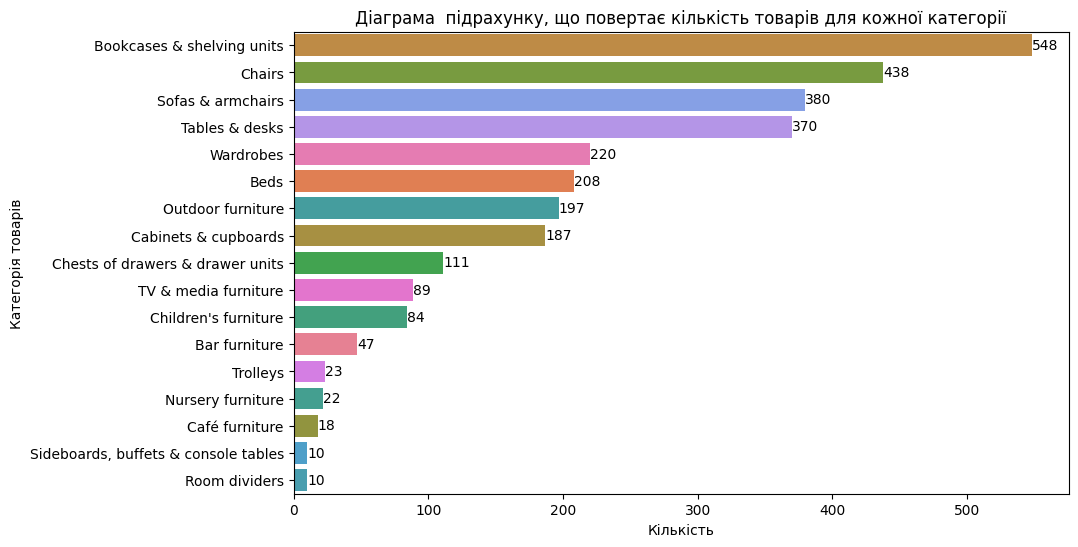

In [41]:
plt.figure(figsize=(10,6))
category_order = df_ikea['category'].value_counts().index
ax=sns.countplot(y = 'category', data = df_ikea, order=category_order, hue=df_ikea['category'])

for i in ax.containers:
  ax.bar_label(i,fontsize=10)


plt.title('Діаграма  підрахунку, що повертає кількість товарів для кожної категорії')
plt.xlabel('Кількість')
plt.ylabel('Категорія товарів')
plt.show()

**Висновок**: найбільшою кількістю товарів представлена категорія "Bookcases & shelving units"

Виведемо найдорожчі категорії товарів

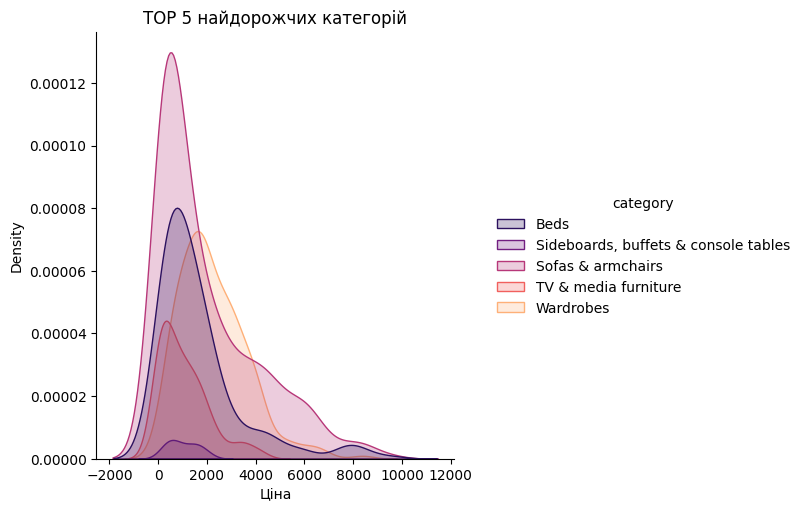

In [42]:
median_prices = df_ikea.groupby('category')['price'].median()
top_5_categories = median_prices.sort_values(ascending=False).head(5).index.tolist()
df_top5 = df_ikea[df_ikea['category'].isin(top_5_categories)]

# plt.figure(figsize=(10,6))
sns.displot(x='price', hue='category', data=df_top5, fill=True, kind='kde', palette='magma')
plt.title('ТОР 5 найдорожчих категорій')
plt.xlabel('Ціна')
plt.show()

Проаналізуємо розподіл цін по категоріях. Для цього побудуємо коробкову діаграму (boxplot)

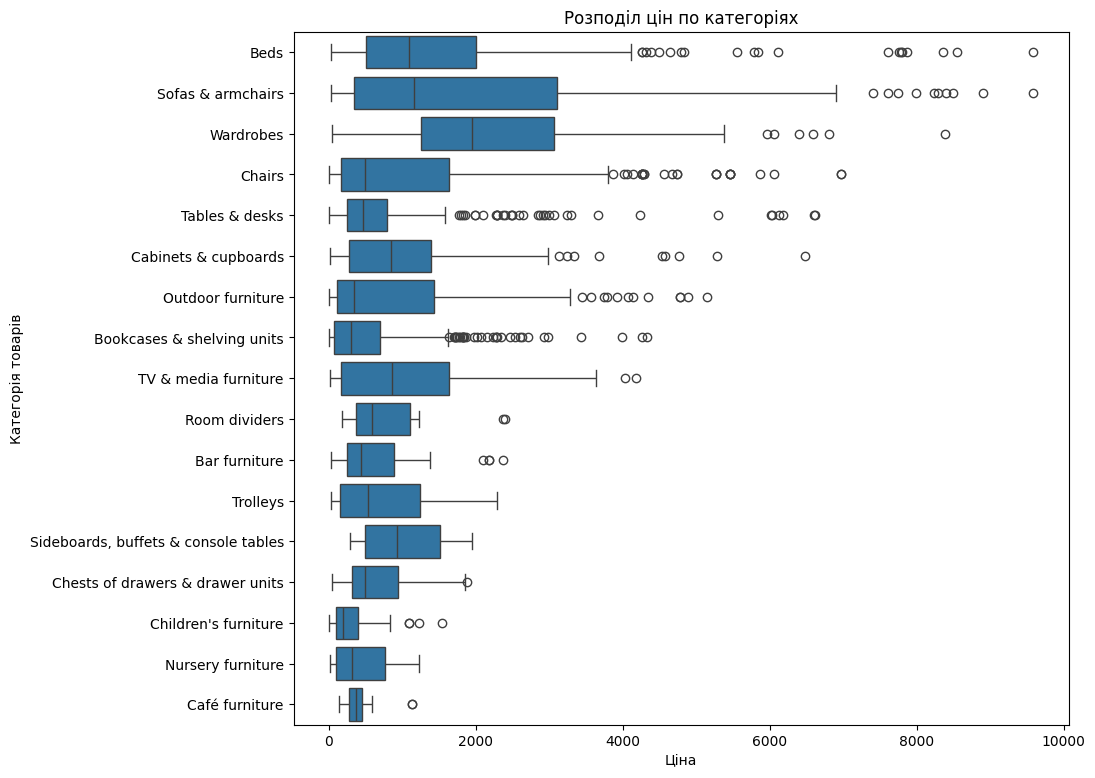

In [ ]:
plt.subplots(figsize = (10,9))
category_count = df_ikea['category'].value_counts().index
sns.boxplot(data=df_ikea.sort_values(by='price', ascending=False), x='price', y='category')
plt.title('Розподіл цін по категоріях')
plt.xlabel('Ціна')
plt.ylabel('Категорія товарів')
plt.show()

**Висновок**: найбільше викидів від середньої ціни ми бачимо у категоріях Sofas & armchairs та Beds, дивани є найпопулярнішим типом меблів, в середньому найдорожча категорія - Wardrobes

Проаналізуємо скільки товарів з нашого каталогу продаються онлайн та відповідно офлайн

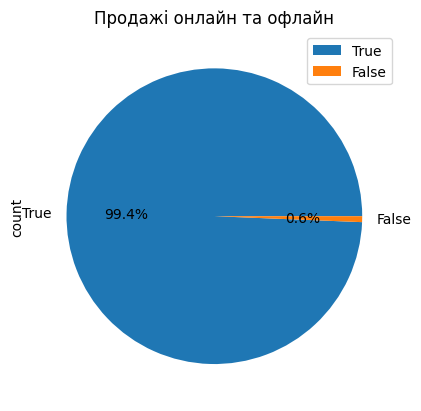

In [43]:
df_ikea['sellable_online'].value_counts().plot(kind = "pie", legend = True, autopct='%1.1f%%' )
plt.title('Продажі онлайн та офлайн')
plt.show()

**Висновок**: переважають онлайн продажі (99%). Тобто розподіл є не рівномірним, і дані цього стовпчика ми не можемо використовувати для подальшого аналізу.

Проаналізуємо яка кількість товарів продається в кількоx кольорах

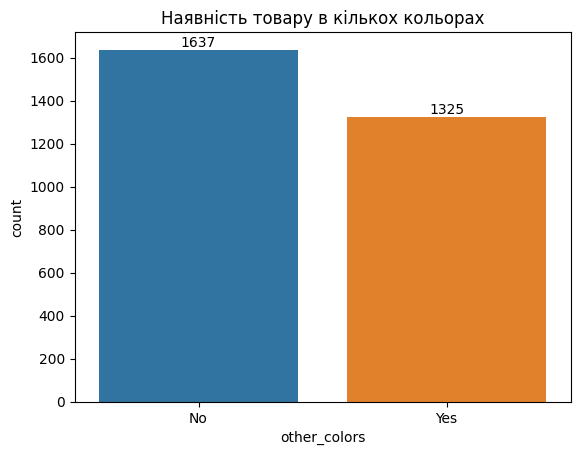

In [44]:
df_ikea['other_colors'].value_counts(normalize=True).sort_values(ascending=False)
ax=sns.countplot(x=df_ikea['other_colors'], hue=df_ikea['other_colors'])
for i in ax.containers:
  ax.bar_label(i)

plt.title('Наявність товару в кількох кольорах')
plt.show()

**Висновок**: Переважна більшість товарів каталогу має лише один колір

!!!!Снепшот по всьому для перевірки явник екстремумів в залежності від кольору.
Тут наприклад ми бачимо що монохромні речі коштують в середньому дорожче, зазвичай вони вищі і більші (з чого можемо зробити гіпотезу що це великогабаритні речі)

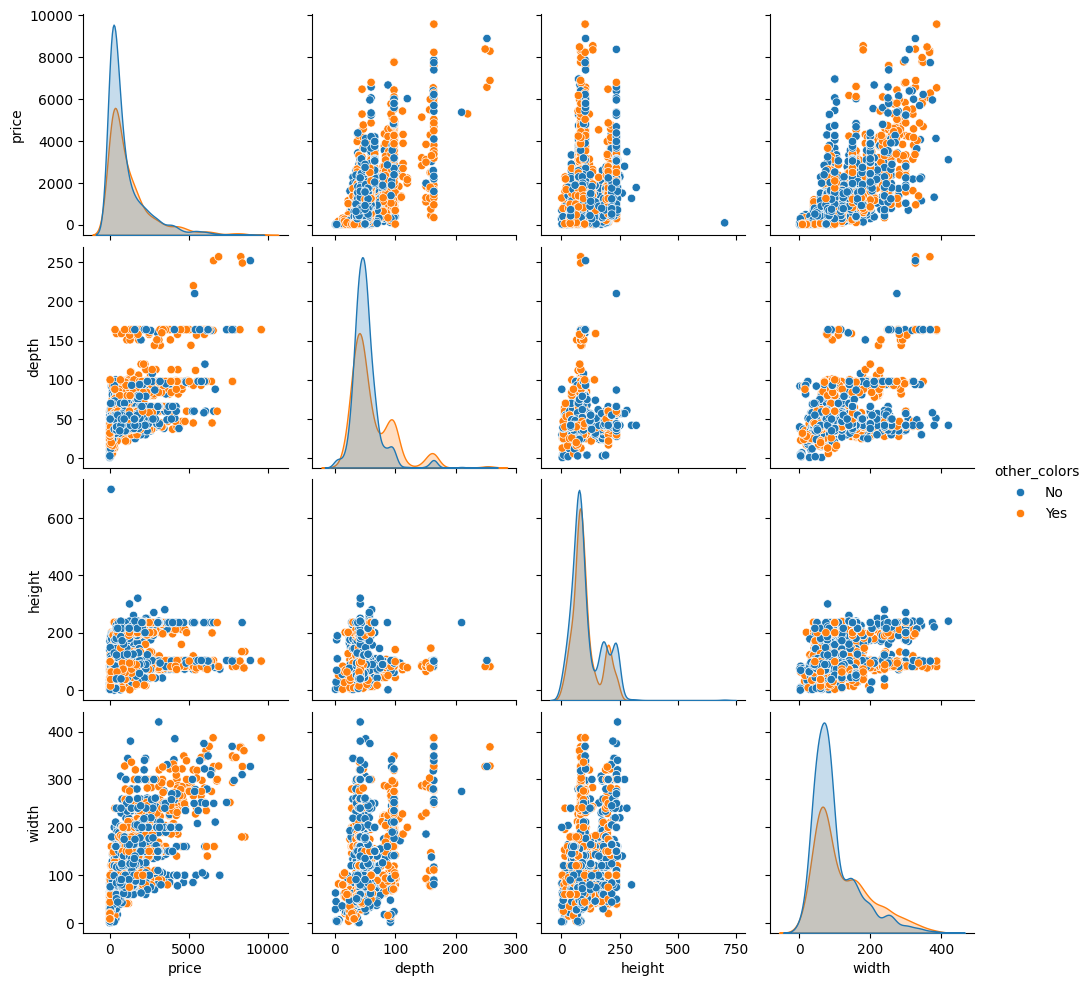

In [45]:
sns.pairplot(df_ikea[['price', 'depth', 'height', 'width', 'other_colors', 'category']], hue = 'other_colors');

Проаналізуємо, як залежить середня ціна товвару від категорії. Виконаємо групування, а далі побудуємо графік (lineplot)

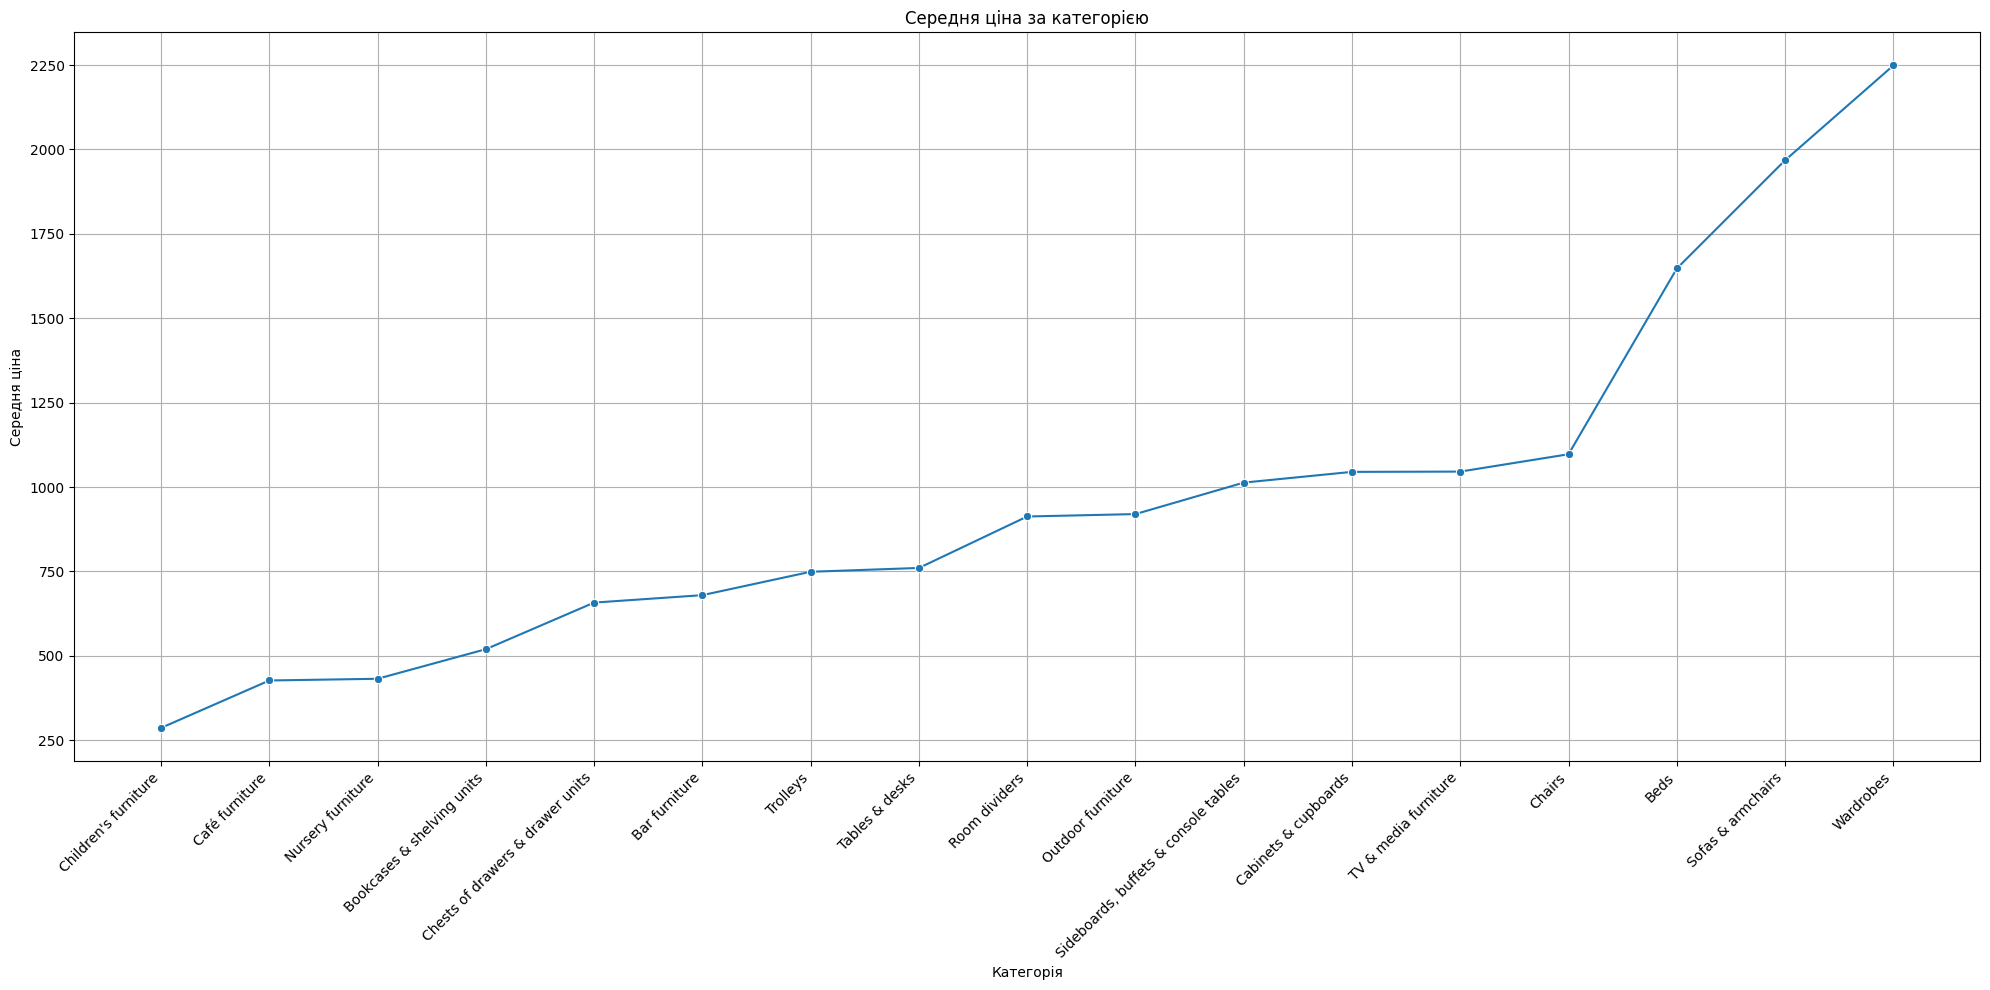

In [46]:
average_prices_by_category = df_ikea.groupby('category')['price'].mean().sort_values()


plt.figure(figsize=(20, 10))
sns.lineplot(x=average_prices_by_category.index, y=average_prices_by_category.values, marker='o')
plt.title('Середня ціна за категорією')
plt.xlabel('Категорія')
plt.ylabel('Середня ціна')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

**Висновок**: Як бачимо залежність існує. Шафи, ліжка, дивани мають найбільшу середню ціну, а дитячі меблі - найменшу середню ціну

А тепер перевіримо, як залежить середня ціна на товари від дизайнера, який проектує їх. Для цього ми згрупуємо за дизайнером і знайдемо середню ціну товару. Виведемо тоp 10 дизайнерів з найвищою середньою ціною на товари

In [69]:
average_prices_by_designer = round(df_ikea.groupby('designer_new')['price'].mean().sort_values(ascending=False).head(10),0)
average_prices_by_designer=average_prices_by_designer.sort_values()
print(average_prices_by_designer)

designer_new
Ehlén Johansson/Karl Malmvall                                  4565.0
IKEA of Sweden/J Marnell/S Lanneskog                           4668.0
Andreas Fredriksson/Marcus Arvonen                             4785.0
Ehlén Johansson/Ola Wihlborg                                   5042.0
Ehlén Johansson/Francis Cayouette/IKEA of Sweden               5045.0
Ebba Strandmark/Ehlén Johansson/IKEA of Sweden/Ola Wihlborg    5353.0
Carl Öjerstam/J Marnell/S Lanneskog                            5370.0
Henrik Preutz/IKEA of Sweden                                   5519.0
J Marnell/Ola Wihlborg/S Lanneskog                             5951.0
Ehlén Johansson/Fredriksson/Hilland/L Löwenhielm               7988.0
Name: price, dtype: float64


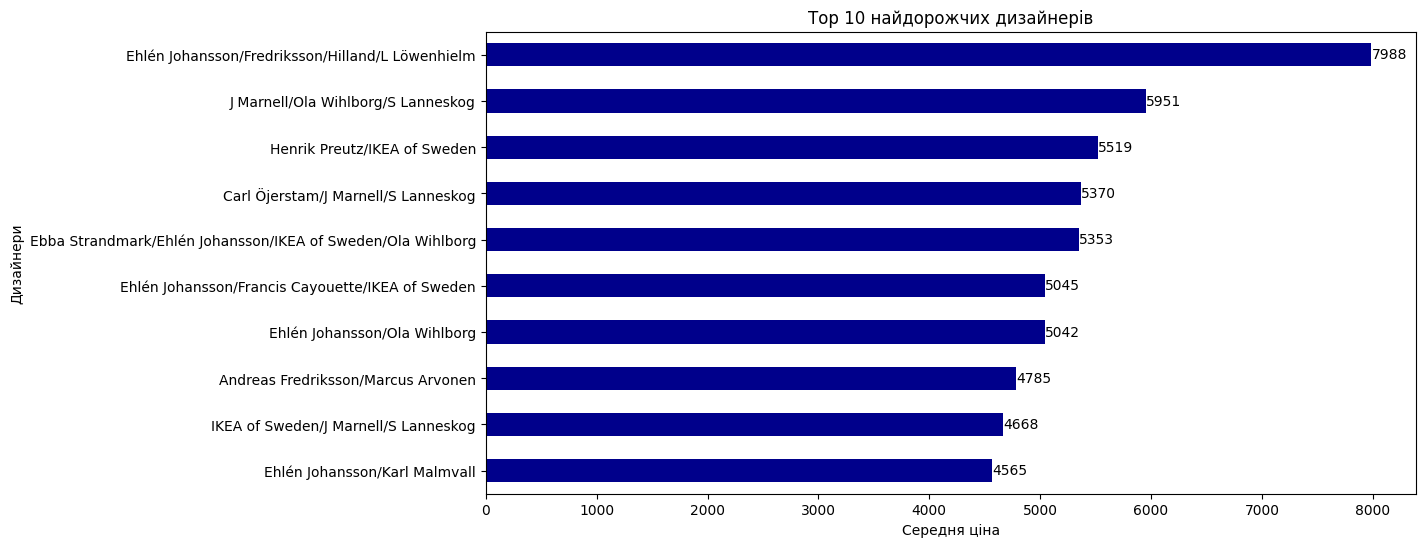

In [71]:
# Будуємо гістограму тоp 10 дизайнерів з найвищою середньою ціною на товари
plt.figure(figsize=(12,6))
ax=average_prices_by_designer.plot(kind = "barh", legend=False, color="darkblue")

for i in ax.containers:
  ax.bar_label(i,fontsize=10)

plt.title('Тоp 10 найдорожчих дизайнерів')
plt.xlabel('Середня ціна')
plt.ylabel('Дизайнери')

plt.show()

In [73]:
#Згрупуємо за доступність онлайн і знайдемо медіану ціну товару
median_prices_by_sellable_online= round((df_ikea.groupby('sellable_online')['price'].median().sort_values().head(10)),2)
print(median_prices_by_sellable_online)

sellable_online
False    200.0
True     575.0
Name: price, dtype: float64


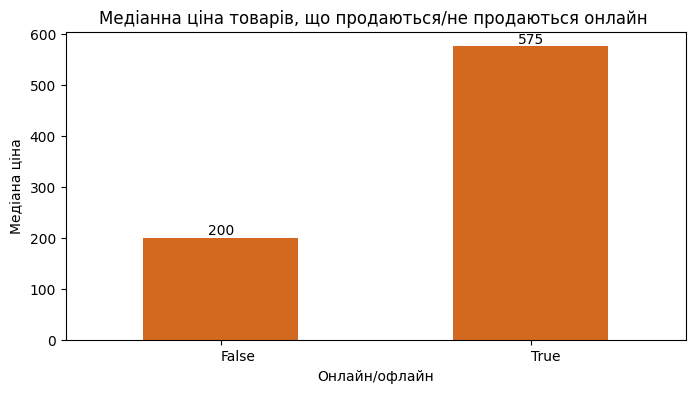

In [74]:
# Будуємо гістограму
plt.figure(figsize=(8, 4))

ax=median_prices_by_sellable_online.plot(kind = "bar", legend=False, color="chocolate")

for i in ax.containers:
  ax.bar_label(i)

plt.title('Медіанна ціна товарів, що продаються/не продаються онлайн ')
plt.xlabel('Онлайн/офлайн')
plt.ylabel('Медіана ціна')
plt.xticks(rotation=0, ha='left')


plt.show()

In [75]:
# Розподілимо товари по дизайнерах(підрахуємо кількість товарів, які приходяться на кожного дизайнера)
count_items_by_designer = df_ikea['designer_new'].value_counts().head(15)
count_items_by_designer_sort=count_items_by_designer.sort_values()
print(count_items_by_designer_sort)

designer_new
Eva Lilja Löwenhielm               41
Ebba Strandmark                    42
Nike Karlsson                      43
IKEA of Sweden/Jon Karlsson        46
E Lilja Löwenhielm/K Malmvall      55
Carina Bengs                       60
Henrik Preutz                      64
K Hagberg/M Hagberg                98
unknow                            102
Jon Karlsson                      106
Ola Wihlborg                      128
Francis Cayouette                 131
Ehlén Johansson                   136
Ehlén Johansson/IKEA of Sweden    138
IKEA of Sweden                    683
Name: count, dtype: int64


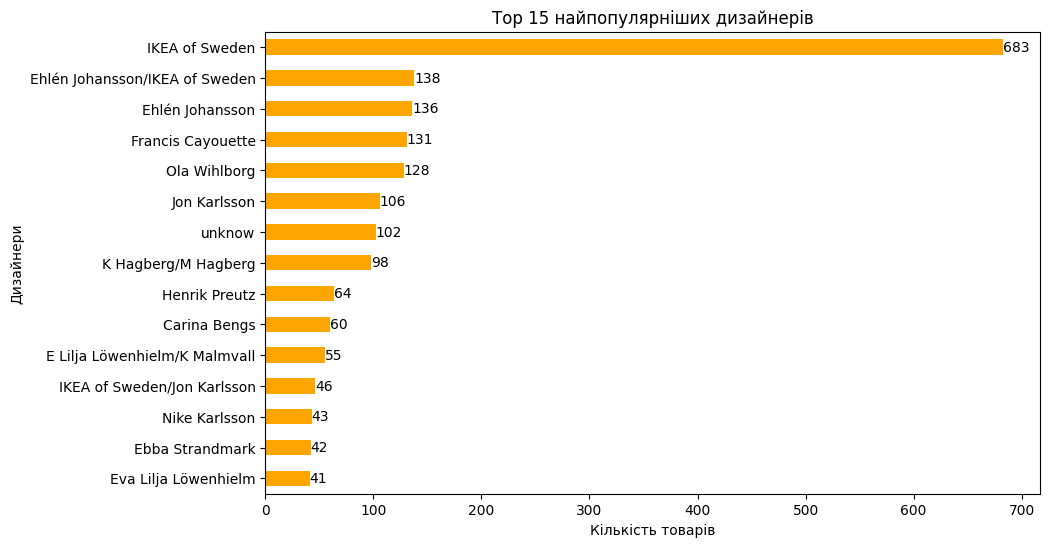

In [76]:
plt.figure(figsize=(10,6))
ax=count_items_by_designer_sort.plot(kind = "barh", legend=False, color="orange")

for i in ax.containers:
  ax.bar_label(i,fontsize=10)

plt.title('Тоp 15 найпопулярніших дизайнерів')
plt.xlabel('Кількість товарів')
plt.ylabel('Дизайнери')

plt.show()

In [78]:
# Оберемо товари на які була зроблена знижка
df_ikea_old_new_price=df_ikea[df_ikea['old_price'].notna()]
print(df_ikea_old_new_price)

                     name  ...  discount
9     EKEDALEN / EKEDALEN  ...  0.083789
32    NORRÅKER / NORRÅKER  ...  0.085921
39    EKEDALEN / EKEDALEN  ...  0.083789
42    NORRÅKER / NORRARYD  ...  0.085921
45    NORRÅKER / NORRÅKER  ...  0.085921
...                   ...  ...       ...
2953              ELVARLI  ...  0.282421
2956              ELVARLI  ...  0.112397
2959              ELVARLI  ...  0.104274
2960              ELVARLI  ...  0.120000
2961              ELVARLI  ...  0.123003

[305 rows x 13 columns]


In [79]:
# Проаналізуємо як змінилася середня ціна деяких товарів після зниження ціни
average_old_new_prices_by_category = df_ikea_old_new_price.groupby(['category']).agg({'old_price':'mean','price':'mean'})
print(average_old_new_prices_by_category)

                                    old_price        price
category                                                  
Bar furniture                     1781.000000  1630.000000
Beds                              3751.666667  3182.611111
Bookcases & shelving units        8132.913043  1035.530435
Cabinets & cupboards              5237.416667  1295.333333
Chairs                            7012.783784  1559.443243
Chests of drawers & drawer units  1580.000000  1264.000000
Outdoor furniture                 8217.421053  1613.105263
Room dividers                     2501.666667  2001.666667
Sofas & armchairs                 4671.854839  3198.241935
TV & media furniture              2162.777778  1917.000000
Tables & desks                    3952.812500  3354.937500
Wardrobes                         2522.844828  2119.310345


Text(0.5, 0, 'Середня ціна')

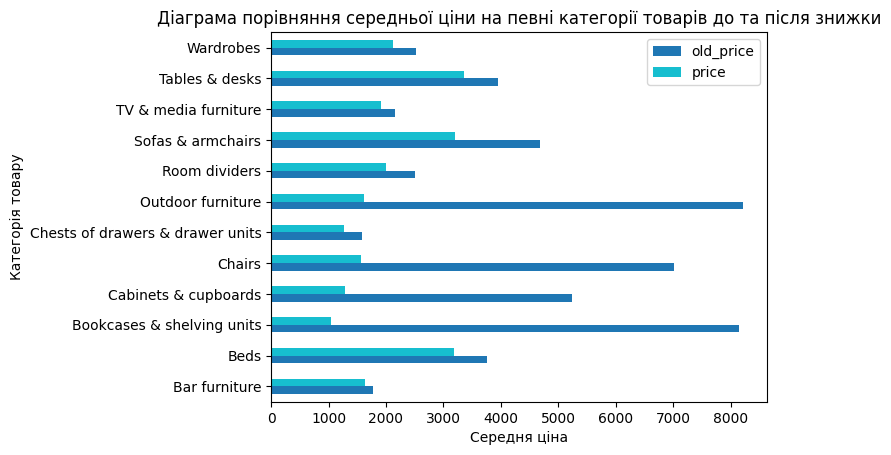

In [80]:
average_old_new_prices_by_category.plot(kind = "barh", legend=True, color=['tab:blue', 'tab:cyan'])
plt.title('Діаграма порівняння середньої ціни на певні категорії товарів до та після знижки')
plt.ylabel('Категорія товару')
plt.xlabel('Середня ціна')


Проаналізуємо залежність ціни від таких  характеристик (показників) як:  висота, ширина і глибина

In [81]:
df_items_size=df_ikea[['price', 'depth','width','height']]
print(df_items_size)

       price  depth  width  height
0      265.0    NaN   51.0    99.0
1      995.0    NaN   80.0   105.0
2     2095.0    NaN    NaN     NaN
3       69.0   50.0   60.0   100.0
4      225.0   60.0   74.0    43.0
...      ...    ...    ...     ...
2957  2045.0   66.0  200.0   236.0
2958   750.0   50.0   91.0     NaN
2959  1572.0   50.0  135.0     NaN
2960   924.0   50.0  175.0     NaN
2961  2745.0   50.0  178.0     NaN

[2962 rows x 4 columns]


Метод pandas corr() забезпечує простий спосіб обчислення кореляції для датафрейму. Отримуємо матрицю кореляції

In [82]:
# Створимо матрицю кореляції
df_corr=df_items_size.corr(method='pearson')
print(df_corr)

           price     depth     width    height
price   1.000000  0.630683  0.720389  0.278548
depth   0.630683  1.000000  0.424394 -0.099405
width   0.720389  0.424394  1.000000  0.368775
height  0.278548 -0.099405  0.368775  1.000000


Візуалізуємо матрицю кореляції  за допомогою теплової карти

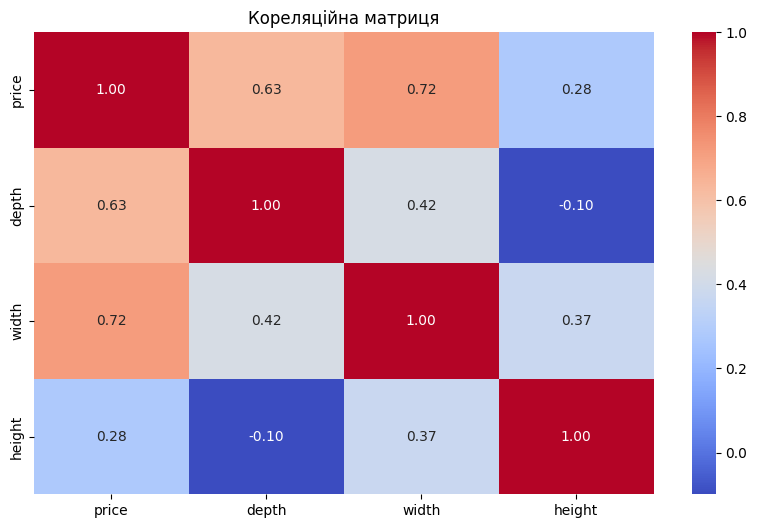

In [83]:
# Візуалізуємо матрицю кореляції за допомогою теплової карти
plt.figure(figsize=(10,6))
sns.heatmap(df_corr,annot=True,cmap='coolwarm',fmt='.2f')
plt.title('Кореляційна матриця')
plt.show()

**Висновок**: з теплової карти можна зробити висновок, що ширина і глибина впливають на ціну, тобто існує певний зв'язок  між ціною і габаритами товару.

Проаналізуємо розподіл цін на товари більш детально. На основі статистичних показників медіани і середнього арифметичного припустили, що розподіл цін на товари не нормальний

## 4. Перевірка гіпотез
- **Гіпотеза 1**: Розподіл ціни в наборі має ознаки не нормального розподілу
- **Нульова гіпотеза(Н0)**: випадкова величина ціни розподілена нормально
- **Альтернативна гіпотеза (Н1)**: випадкова величина ціни розподілена не нормально

Для оцінки розподілу цін побудуємо  коробкову діаграму (boxplot)

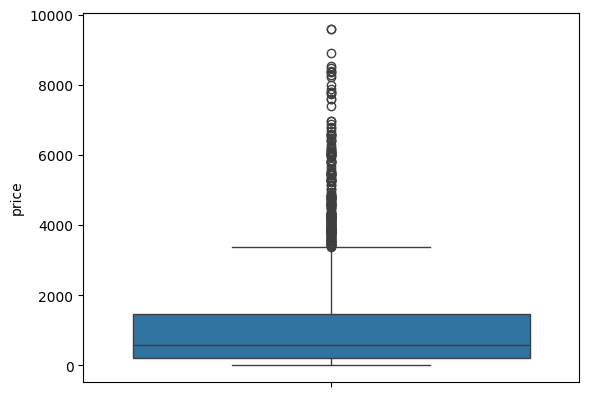

In [84]:
# будуємо коробкову діаграму (boxplot)
sns.boxplot(df_ikea['price'])
plt.show()

**Висновок**: 50% всіх записів знаходяться в діапазоні від 50 до 1400. Але є багато товарів, де ціни дуже високі. Тобто ціновий діапазон дуже варіативний і неоднорідний.

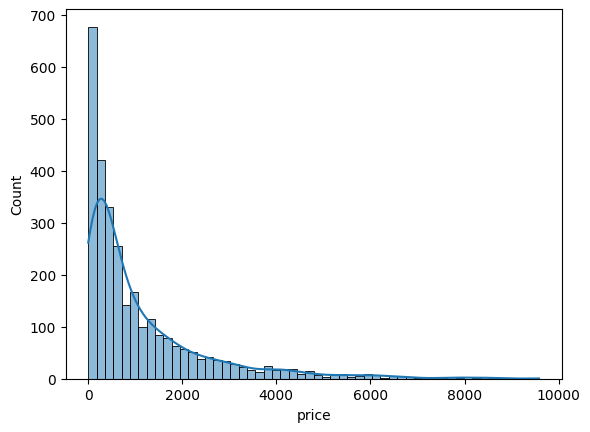

In [85]:
# будуємо histplot
sns.histplot(df_ikea['price'], kde=True)
plt.show()

Форми дзвіночка не спостерігається. Це вказує, що розподіл не нормальний.

Проведемо перевірку на нормальність тестом Шапіто-Вілка:

In [86]:
# test Шапіро-Вілка

sample=df_ikea['price']
statistic, p_val=stats.shapiro(sample)
print(f'p-value: {p_val:.10f}')
print(f'statistic: {statistic:.10f}')

p-value: 0.0000000000
statistic: 0.7326762705


**Висновок**:  За результатами проведних тестів, можна достовірно стверджувати, що розподіл ціни в наборі  не має нормального закону розподілу. Отже, має місце альтернативна гіпотеза.

Для того, щоб перевести наші показники ненормального розподілу ціни в нормальний і далі можна було б використовувати, потрібно застосувати до ціни функцію логарифмування.

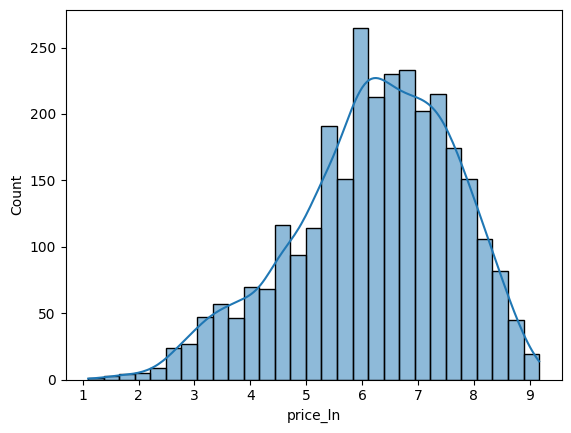

In [87]:
# логарифмування ціни
df_ikea['price_ln']=np.log(df_ikea['price'])
# будуємо гістограму
sns.histplot(df_ikea['price_ln'], kde=True)
plt.show()

**Висновок**: в результаті логарифмування отримали нормальний розподіл ціни

- **Гіпотеза 2**: Товари, які мають варіації кольорів, мають вищу ціну
- **Нульова гіпотеза(Н0):** Товари, які представлені в різних кольорах та товари, які представлені лише в одному кольорі  мають *однакову середню ціну.*
- **Альтернативна гіпотеза(H1)**: Товари, які представлені в різних кольорах та товари, які представлені лише в одному кольорі  мають *різну середню ціну.*


Використаємо t-test

In [88]:
# t-test -  це статистичний тест, який використовується для визначення того, чи існує значуща різниця між середніми значеннями двох вибірок.


# Параметри st.ttest_ind

# equal_var - встановлюється в True , якщо дисперсії приблизно рівні, і в False , якщо ні.

# alternative - тип альтернативної гіпотези:

# 'two-sided' - вказує на те, що середні не рівні.

# 'less' - означає, що перше середнє менше за друге.

# 'greater' - означає, що перше середнє більше за друге.

# Значення, що повертаються:

### statistic - значення t-статистики .

### pvalue - p-значення.


# Формуємо групи:
single_colour=df_ikea[df_ikea['other_colors']=='No']['price']
myltiple_colour=df_ikea[df_ikea['other_colors']=='Yes']['price']


t_statistic, p_value = ttest_ind(single_colour, myltiple_colour, equal_var=False)
print(f"T-statistic: {t_statistic:.2f}")
print(f"P-value: {p_value:.3f}")

T-statistic: -5.45
P-value: 0.000


In [89]:
if p_value > 0.05:
    print("We support the null hypothesis, the mean values are equal")
else:
    print("We reject the null hypothesis")

We reject the null hypothesis


Нас цікавить p-value. Якщо воно менше α (зазвичай 0,05), то t-статистика знаходиться в критичній області, тому ми повинні прийняти альтернативну гіпотезу. Якщо ж p-value більше α - приймаємо нульову гіпотезу про рівність середніх.

**Висновок**: Товари, які представлені в різних кольорах та товари, які представлені лише в одному кольорі мають різну середню ціну.

Використаємо Mann-Whitney-Wilcoxon test

Тест Манна-Уітні для перевірки статистичної значущості різниці між двома незалежними вибірками;
statistic - значення тестової статистики, яке вказує на розмір рангової різниці між групами;
p_value - ймовірність отримати такий чи більший statistic при гіпотезі про відсутність різниці між групами;

In [90]:
statistic, p_value = mannwhitneyu(single_colour, myltiple_colour)

print(f"Statistic: {statistic:.2f}")
print(f"P-value: {p_value:.3f}")

Statistic: 930008.50
P-value: 0.000


**Висновок**: Має місце  **Альтернативна гіпотеза(H1)**: Товари, які представлені в різних кольорах та товари, які представлені лише в одному кольорі  мають *різну середню ціну.*

- **Гіпотеза 3**: Товари, які мають більші габарити, мають вищу ціну.
- **Нульова гіпотеза(Н0)**: Товари різного розміру мають однакову середню ціну.
- **Альтернативна гіпотеза(H1)**: Товари різного розміру мають різну середню ціну.

In [91]:
#Заповнення порожніх значень вручну
# Фактори  габаритів можна згрупувати за категорією та заповнити відсутні значення медіанними значеннями для кожної категорії.
# Cпочатку знаходимо  медіану для  'depth', 'height', 'width' за групами товарів
median_d = df_ikea.groupby(['category'])['depth'].median()
median_h = df_ikea.groupby(['category'])['height'].median()
median_w = df_ikea.groupby(['category'])['width'].median()


# Заповнення пропущених значень та створення нових колонок
df_ikea = df_ikea.set_index(['category'])
df_ikea['depth_1'] = df_ikea['depth'].fillna(median_d)
df_ikea['height_1'] = df_ikea['height'].fillna(median_h)
df_ikea['width_1'] = df_ikea['width'].fillna(median_w)

df_ikea=df_ikea.reset_index()

In [92]:
print(df_ikea['depth_1'].isna().sum())


0


В попередньому блоці ми обчислювали матрицю кореляції, включивши розміри товарів, будували теплову карту, яка говорила про те, що існує певна залежність.
Використаємо метод лінійної регресії

In [93]:
# ми обчислювали матрицю кореляції, включивши розміри товарів,
# будували теплову карту,
# яка говорила про те, що існує певна залежність.
# Використаємо метод лінійної регресії
X=df_ikea[['depth_1','height_1', 'width_1']]
y=df_ikea['price_ln']
X=sm.add_constant(X, prepend=False)
model=sm.OLS(y,X)
res=model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               price_ln   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     627.5
Date:                Wed, 21 May 2025   Prob (F-statistic):          1.28e-315
Time:                        18:15:34   Log-Likelihood:                -4547.1
No. Observations:                2962   AIC:                             9102.
Df Residuals:                    2958   BIC:                             9126.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
depth_1        0.0118      0.001     13.505      0.0

**Висновок**: знову підтверджується альтернативна гіпотеза, що товари різного розміру мають різну середню ціну.

### 05. Машинне навчання (ML)

Потрібно створити модель, яка б передбачала ціну на меблі нашого набору.
Основні етапи:
1. Попередня обробка, що включає: імпутування, кодування та масштабування даних, створення конвеєра (pipeline)
2. Вибір моделі
3. Навчання моделі
3. Налаштування гіперпараметрів
4. Оцінювання продуктивності моделі (вимірювання ефективності на невидимих даних)





1. Готуємо дані:
-  визначаємо стовпці, які будемо використовувати для прогнозування (X);
-  визначаємо стовпець, який ми хочемо спрогнозувати, це буде ціна на меблі (у)


In [94]:
# Готуємо набори даних:
# Включаємо в X набір стовпців (факторів), які мають значення для прогнозування ціни на меблі
X=df_ikea[['depth','width','height','name','category','designer_new','other_colors']]
# Наша ціль target, ціна на меблі
y=df_ikea['price']

#Cпочатку проаналізуємо вплив факторів на зразок!!!

# Розбиваємо на тренувальні та тестові набори
X_train,X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# Створюємо конвеєр pipeline

numeric_transf=Pipeline(steps=[
    ('scaler', StandardScaler()), #масштабування даних
    ('impute', SimpleImputer(strategy='median')) #заміна числових даних, які пропущені, медіанними
])
categorical_transf=Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')), # заміна пропущених категоріальних даних, найбільш популярним значенням
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # кодування номінальних даних
])
preprocessor=ColumnTransformer(transformers=[
    ('numeric', numeric_transf,['depth', 'width','height']),
    ('categorical',categorical_transf, ['name','category','designer_new','other_colors'])
])

# Створюємо конвеєр pipeline з моделю DecisionTreeRegressor

dtr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dtr', DecisionTreeRegressor(max_depth=10, random_state=42))
])


# Передаємо набори даних для навчання, тренуємо модель
dtr.fit(X_train, y_train)

# Отримуємо передбачення
dtr_predict=dtr.predict(X_test)

# Отримуємо основні показники по обраній моделі
print('\nResults of DecisionTreeRegressor')
print('R^2 : {:.5f}'.format(dtr.score(X_test, y_test)))
print('MAE : {:.5f}'.format(sk.metrics.mean_absolute_error(dtr_predict, y_test)))
print('MSE : {:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(dtr_predict, y_test))))

# Проаналізуємо фактори, які проявляють значний вплив на модель
feature_importances = dtr.named_steps['dtr'].feature_importances_

numeric_features = ['depth', 'height', 'width']
categorical_features = ['name','category', 'designer_new', 'other_colors']

# Отримання назв колонок після препроцесингу
cat_columns = dtr.named_steps['preprocessor'].named_transformers_['categorical'].named_steps[
    'onehot'].get_feature_names_out(categorical_features)
final_columns = np.concatenate([numeric_features, cat_columns])

# Створення DataFrame для важливості факторів
importance_df = pd.DataFrame({
    'Feature': final_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Групування важливості по основним факторам
grouped_importances = {key: 0 for key in ['name','category', 'designer_new', 'other_colors', 'depth', 'height', 'width']}
for _, row in importance_df.iterrows():
    for key in grouped_importances:
        if row['Feature'].startswith(key):
            grouped_importances[key] += row['Importance']
            break

grouped_importances_df = pd.DataFrame.from_dict(grouped_importances, orient='index', columns=['Importance'])
grouped_importances_df = grouped_importances_df.sort_values(by='Importance', ascending=False)
grouped_importances_df['Importance (%)'] = (grouped_importances_df['Importance'] / grouped_importances_df[
    'Importance'].sum()) * 100
print(grouped_importances_df)




Results of DecisionTreeRegressor
R^2 : 0.72641
MAE : 463.31342
MSE : 717.85451
              Importance  Importance (%)
height          0.623447       62.344655
depth           0.118142       11.814205
name            0.080390        8.038950
designer_new    0.074530        7.453042
width           0.058930        5.893006
category        0.040146        4.014629
other_colors    0.004415        0.441513


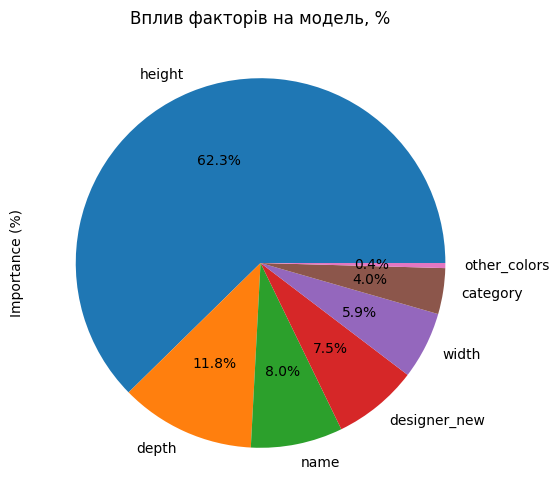

In [95]:
plt.figure(figsize=(10,6))
grouped_importances_df['Importance (%)'].plot(kind = "pie", legend = False, autopct='%1.1f%%' )
plt.title('Вплив факторів на модель, %')
plt.show()

**Висновок**: Глянувши на категоріальні ознаки, вони в такому вигляді не несуть ніякої користі порівняно з числовими ознаками. Отже, потрібно їх замінити медіанними.
Ми вже виконали заміну висоти, глибини та ширини медіанними по категоріях. Аналогічно виконаємо заміну  для категорії та дизайнера

In [97]:
# Створення нової колонки 'other_colors_1', де замінимо
df_ikea['other_colors_1'] = df_ikea['other_colors'].map(dict(Yes=1, No=0))


In [ ]:
print(df_ikea['other_colors_1'])
print(df_ikea['other_colors_1'].isnull().sum())

0       0
1       0
2       0
3       1
4       0
       ..
2957    0
2958    0
2959    0
2960    0
2961    0
Name: other_colors_1, Length: 2962, dtype: int64
0


In [98]:
# Фактори категорію та дизайнера  замінимо медіанами для відповідної категорії та дизайнера.

median_price=df_ikea.groupby(['category'])['price'].median()
median_dsgn=df_ikea.groupby(['designer_new'])['price'].median()

df_ikea=df_ikea.set_index(['category'])
df_ikea['category_median_price']=median_price
df_ikea=df_ikea.reset_index()
df_ikea=df_ikea.set_index(['designer_new'])

df_ikea['designer_median_price']=median_dsgn
df_ikea=df_ikea.reset_index()


In [99]:
print(median_dsgn)
print(df_ikea['designer_new'].isnull().sum())

designer_new
A Fredriksson/H Preutz                                   31.0
A Fredriksson/HAY/J Hultqvist/W Chong                  2575.0
A Fredriksson/IKEA of Sweden/J Hultqvist/W Chong        675.0
A Fredriksson/J Hultqvist/Lisa Norinder/W Chong         889.0
A Fredriksson/J Hultqvist/Mikael Warnhammar/W Chong    2575.0
                                                        ...  
Tom Dixon                                               595.0
Tord Björklund                                          495.0
Virgil Abloh                                            480.0
Wiebke Braasch                                          410.0
unknow                                                  295.0
Name: price, Length: 200, dtype: float64
0


In [106]:
# Побудуємо кілька моделей і визначимо, яка є найкращою на базі метрик якості моделі
# Основні показники оцінки регресійної моделі:
# MAE (Mean Absolute Error) - середня абсолютна помилка, яка вказує, як далеко середні прогнози лежать від коректних відповідей
# MSE (Mean Squared Error) - середня квадратична помилка з усередненням квадратів відстаней  передбачених від реальних відповідей
# R^2 (Коефіцієнт детермінації) - чим ближче він до 1, тим краща модель. А якщо R^2 наближається до 0 , то дана модель не має сенсу.

# Готуємо навчальний набір даних
X = df_ikea[['width_1','depth_1','height_1', 'category_median_price','designer_median_price','other_colors_1']]
# Цільовий набір, target
Y = df_ikea['price']
# print(X)
# print(Y)

# Розбиваємо на тренувальні та тестові набори
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

# Шукаємо найкращу модель
def getBestRegressor (X, Y):
    X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)
    models = [
        sk.linear_model.LinearRegression(),
        sk.linear_model.LassoCV(),
        sk.linear_model.RidgeCV(),
        sk.svm.SVR(kernel='linear'),
        sk.neighbors.KNeighborsRegressor(n_neighbors=16),
        sk.tree.DecisionTreeRegressor(max_depth=10, random_state=42),
        RandomForestRegressor(random_state=42),
        GradientBoostingRegressor()
    ]

    TestModels = pd.DataFrame()
    res = {}
    tmp = {}

# Оцінка кожної моделі та збереження результатів
# Для кожної моделі обчислюються метрики R^2, MAE та RMSE за допомогою тестового набору.
# Результати зберігаються в DataFrame TestModels.
    for model in models:
        m = str(model)
        tmp['Model'] = m[:m.index('(')]
        model.fit(X_train, Y_train)
        tmp['R^2'] = '{:.5f}'.format(model.score(X_test, Y_test))
        tmp['MAE'] = '{:.5f}'.format(sk.metrics.mean_absolute_error(model.predict(X_test), Y_test))
        tmp['RMSE'] = '{:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(model.predict(X_test), Y_test)))

        TestModels = pd.concat([TestModels, pd.DataFrame([tmp])])

# Підготовка результатів для виведення (Результати зберігаються в словник res)
    TestModels.set_index('Model', inplace=True)
    res['model'] = TestModels
    res['X_train'] = X_train
    res['Y_train'] = Y_train
    res['X_test'] = X_test
    res['Y_test'] = Y_test
    return res

# Після визначення функції getBestRegressor, використовуються певні дані
#(X1 та Y1 з нашого прикладу) для оцінки регресійних моделей,
# результати виводяться відсортовані за значенням R^2 в порядку спадання.

X1 = df_ikea[['width_1','depth_1','height_1', 'category_median_price','designer_median_price', 'other_colors_1']]
Y1 = df_ikea['price']

test1 = getBestRegressor(X1, Y1)
test1['model'].sort_values(by='R^2', ascending=False)

#Друкуємо відсортовані результати
print(test1['model'].sort_values(by='R^2', ascending=False))


                               R^2        MAE       RMSE
Model                                                   
RandomForestRegressor      0.81641  344.19037  588.04479
GradientBoostingRegressor  0.78322  399.64150  638.98908
DecisionTreeRegressor      0.73516  419.81216  706.27198
KNeighborsRegressor        0.67911  476.95659  777.42762
SVR                        0.66692  503.97289  792.06148
LinearRegression           0.65876  541.29819  801.70542
RidgeCV                    0.65869  541.28774  801.78975
LassoCV                    0.65782  536.77370  802.79985


**Висновок**: найкращий результат показала RandomForestRegressor (R^2=0.80941) по всіх трьох показниках оцінки регресійної моделі.

Побудуємо barplot коефіцієнтів детермінації для кожної моделі

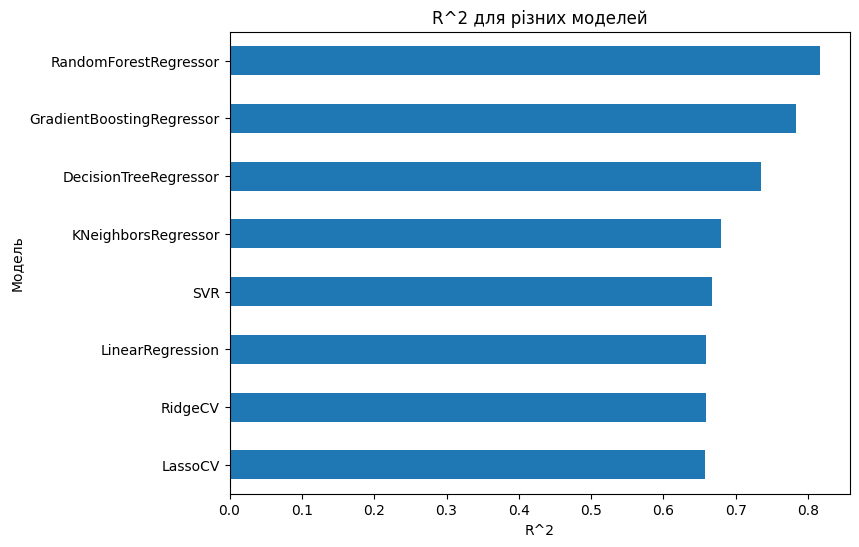

In [105]:
plt.figure(figsize=(8,6))
test1['model']['R^2'] = test1['model']['R^2'].astype(float)  # Convert R^2 values to float
ax=test1['model']['R^2']
ax.sort_values().plot(kind='barh')

# for i in ax.containers:
  # ax.bar_label(i,fontsize=10)


plt.title('R^2 для різних моделей')
plt.xlabel('R^2')
plt.ylabel('Модель')
plt.show()

Продемонструємо показник RMSE для кожної моделі

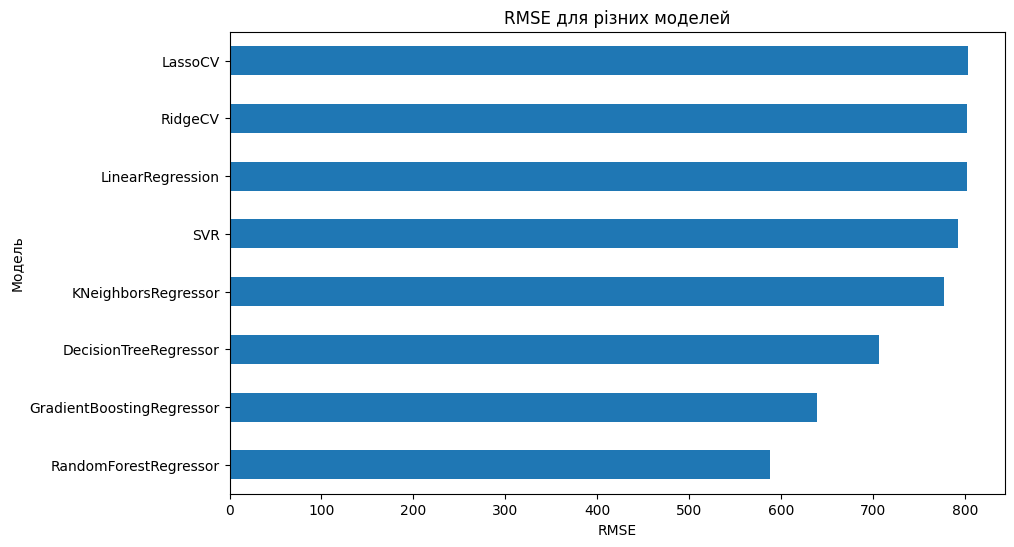

In [104]:
plt.figure(figsize=(10, 6))
test1['model']['RMSE'] = test1['model']['RMSE'].astype(float)
test1['model']['RMSE'].sort_values().plot(kind='barh')
plt.title('RMSE для різних моделей')
plt.xlabel('RMSE')
plt.ylabel('Модель')
plt.show()

Висновок: найкращий результат показала модель RandomForestRegressor

Пошук найкращих гіперпараметрів для нашої моделі


In [108]:
#GridSearchCV
# Зробимо пошук найкращих гіперапараметрів для моделі RandomForestRegressor

X1 = df_ikea[['width_1','depth_1','height_1', 'category_median_price','designer_median_price', 'other_colors_1']]
Y1 = df_ikea['price']

X_train, X_test, Y_train, Y_test=train_test_split(X1, Y1, test_size=0.2, random_state=42)


param_grid = {
  'n_estimators': [100, 200, 300, 400],
  'max_depth': [10,20,30,40],

}

forest_grid=GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
forest_grid.fit(X_train, Y_train)

print('Best Estimator:', forest_grid.best_estimator_)
print('Best Score :', forest_grid.best_score_)
print ('')
print('R^2                      : {:.5f}'.format(r2_score(Y_test, forest_grid.predict(X_test))))
print('MAE                      : {:.5f}'.format(mean_absolute_error(forest_grid.predict(X_test), Y_test)))
print('RMSE                     : {:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(forest_grid.predict(X_test), Y_test))))

print('MAPE                     : {:.5f}'.format(np.mean(np.abs((Y_test - dtr_predict) / Y_test)) * 100))
print('Explained Variance Score : {:.5f}'.format(sk.metrics.explained_variance_score(Y_test, dtr_predict)))
print('Median Absolute Error    : {:.5f}'.format(sk.metrics.median_absolute_error(Y_test, dtr_predict)))
print('Mean Absolute Error      : {:.5f}'.format(sk.metrics.mean_absolute_error(Y_test, dtr_predict)))


print('')

print('Feature importance:')
print('--------------------------------')

for feat, importance in zip(X_train.columns, forest_grid.best_estimator_.feature_importances_):
    print('{:.5f}    {f}'.format(importance, f=feat))


Best Estimator: RandomForestRegressor(max_depth=20, n_estimators=400)
Best Score : 0.8156609186916487

R^2                      : 0.81961
MAE                      : 342.89856
RMSE                     : 582.89529
MAPE                     : 126.23646
Explained Variance Score : 0.72733
Median Absolute Error    : 275.00000
Mean Absolute Error      : 463.31342

Feature importance:
--------------------------------
0.48821    width_1
0.12384    depth_1
0.05268    height_1
0.01972    category_median_price
0.30202    designer_median_price
0.01353    other_colors_1


Після підбору гіперпараметрів показники якості моделі покращилися, коефіціент детермінації ще наблизився до 1.

**Висновок** : найбільший вплив на ціну має розмір товару, а саме ширина, та глибина. А також бачимо значний вплив має медіанна ціна по дизайнеру.

Тепер оцінимо нашу модель, проведемо крос-валідацію (сross_val_score)

RMSE: 597.54
MSE: 357050.55


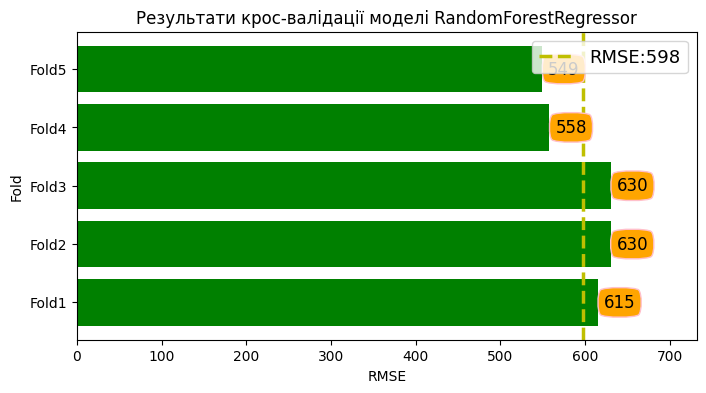

In [ ]:
# оцінимо якість нашої  модель, проведемо крос-валідацію (сross_val_score)
rf_model = RandomForestRegressor()

cv_rf_regression=KFold(n_splits=5, shuffle=True, random_state=42)
neg_mse_scores_rf_regression=cross_val_score(rf_model, X_train, Y_train,
                                             cv=cv_rf_regression, scoring='neg_mean_squared_error')

print('RMSE: {:.2f}'.format(np.sqrt(-neg_mse_scores_rf_regression.mean())))
mse_scores_rf_regression=-neg_mse_scores_rf_regression

mse_mean_rf_regression=mse_scores_rf_regression
mse_mean_rf_regression=mse_scores_rf_regression.mean()

print('MSE: {:.2f}'.format(mse_mean_rf_regression))

# Візуалізація

fig, ax=plt.subplots(figsize=(8,4))
ax.barh(range(len(mse_scores_rf_regression)), np.sqrt(mse_scores_rf_regression),color='green')
ax.set_yticks(range(len(mse_scores_rf_regression)))
ax.set_yticklabels(['Fold{}'.format(i+1)for i in range(len(mse_scores_rf_regression))])
plt.axvline(np.sqrt(mse_mean_rf_regression), color='y', linestyle='dashed',linewidth=2.5, label=f'RMSE:{round(np.sqrt(mse_mean_rf_regression))}')

for i,v in enumerate(mse_scores_rf_regression):
  plt.text(np.sqrt(v)+7, i, f'{round(np.sqrt(v))}', ha='left', va='center', color='black', fontsize=12,
           bbox=dict(facecolor='orange',edgecolor='pink', boxstyle='round4, pad=0.4'))
  ax.set_xlim(0,np.sqrt(mse_mean_rf_regression).max()*1.225)
plt.xlabel('RMSE')
plt.ylabel('Fold')
plt.title('Результати крос-валідації моделі RandomForestRegressor')
plt.legend (loc='upper right', fontsize=13)
plt.gca().grid(False)
plt.show()

**Висновок**: По всіх показниках найкращою моделлю є  RandomForestRegressor